# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/MyDrive/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/MyDrive/assignment3" $datadir # TODO: Fill your assignment3 path
os.chdir(datadir)
!pwd

/content/drive/MyDrive/assignment3


# Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0 : # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    elif rot == 1 :
        return transforms.functional.rotate(img,90)
    elif rot == 2 :
        return transforms.functional.rotate(img,180)
    elif rot == 3 :
        return transforms.functional.rotate(img,270)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [ ]:
"""
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
"""

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomApply([transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)], p=0.3),  
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),  
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset    = CIFAR10Rotation(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset     = CIFAR10Rotation(root='./data', train=False, download=True, transform=transform_test)
testloader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.9882353].


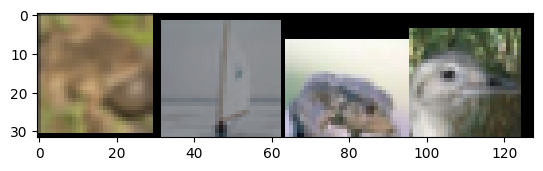

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.9882353].


Class labels:  frog  ship  frog  bird 


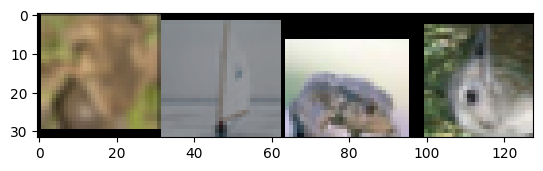

Rotation labels:  270   0     0     90   


In [5]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

---
# Evaluation code

In [4]:
device = 'mps'
device

'mps'

In [5]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            predictions = torch.max(outputs,dim=1).indices
            total += labels.shape[0]
            correct += (predictions==labels).sum().item()

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [6]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

---
## 1. Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [323]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [324]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [79]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results
            predicted = torch.max(outputs,dim=1).indices

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net,testloader,criterion,task)

    print('Finished Training')

In [13]:
checkpoint = torch.load("./models/resnet18_rotation.pth",map_location=torch.device('mps'))
net.load_state_dict(checkpoint['parameters'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [20]:
run_test(net,testloader,criterion,"rotation")

TESTING:
Accuracy of the network on the 10000 test images: 86.13 %
Average loss on the 10000 test images: 0.364


In [326]:
train(net, criterion, optimizer, num_epochs=50, decay_epochs=15, init_lr=0.001, task='rotation')

print('Saving Model ...')
# TODO: Save the model
torch.save({"parameters":net.state_dict(), "optimizer":optimizer.state_dict()}, "./models/resnet18_rotation.pth")
print('Saved Model !')

[1,   100] loss: 1.281 acc: 42.84 time: 3.62
[1,   200] loss: 1.119 acc: 50.42 time: 3.52
[1,   300] loss: 1.107 acc: 51.63 time: 3.52
TESTING:
Accuracy of the network on the 10000 test images: 56.04 %
Average loss on the 10000 test images: 1.037
[2,   100] loss: 1.048 acc: 55.14 time: 3.54
[2,   200] loss: 1.034 acc: 56.01 time: 3.53
[2,   300] loss: 1.005 acc: 56.76 time: 3.54
TESTING:
Accuracy of the network on the 10000 test images: 59.25 %
Average loss on the 10000 test images: 0.972
[3,   100] loss: 0.979 acc: 59.07 time: 3.54
[3,   200] loss: 0.960 acc: 59.30 time: 3.56
[3,   300] loss: 0.954 acc: 59.70 time: 3.57
TESTING:
Accuracy of the network on the 10000 test images: 62.54 %
Average loss on the 10000 test images: 0.895
[4,   100] loss: 0.946 acc: 60.52 time: 3.59
[4,   200] loss: 0.911 acc: 62.16 time: 3.60
[4,   300] loss: 0.926 acc: 61.02 time: 3.56
TESTING:
Accuracy of the network on the 10000 test images: 62.97 %
Average loss on the 10000 test images: 0.897
[5,   100] l

---
## 2.1 Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [29]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
net = resnet18(num_classes=4)
net.load_state_dict(torch.load("./models/resnet18_rotation.pth")["parameters"])
device = "mps"
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for p in net.parameters() : 
    p.requires_grad = False

for weights in net.layer4.parameters() : 
    weights.requires_grad = True

net.fc = torch.nn.Linear(512, 10, True, device)

In [31]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [32]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [37]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.822 acc: 35.46 time: 4.73
[1,   200] loss: 1.585 acc: 42.75 time: 4.54
[1,   300] loss: 1.518 acc: 44.53 time: 4.53
TESTING:
Accuracy of the network on the 10000 test images: 50.89 %
Average loss on the 10000 test images: 1.400
[2,   100] loss: 1.427 acc: 48.48 time: 4.52
[2,   200] loss: 1.419 acc: 48.62 time: 4.62
[2,   300] loss: 1.384 acc: 50.52 time: 4.53
TESTING:
Accuracy of the network on the 10000 test images: 53.34 %
Average loss on the 10000 test images: 1.324
[3,   100] loss: 1.368 acc: 49.88 time: 4.58
[3,   200] loss: 1.366 acc: 50.86 time: 4.54
[3,   300] loss: 1.353 acc: 51.06 time: 4.64
TESTING:
Accuracy of the network on the 10000 test images: 56.47 %
Average loss on the 10000 test images: 1.240
[4,   100] loss: 1.339 acc: 51.43 time: 4.60
[4,   200] loss: 1.343 acc: 51.63 time: 4.55
[4,   300] loss: 1.313 acc: 52.63 time: 4.56
TESTING:
Accuracy of the network on the 10000 test images: 54.48 %
Average loss on the 10000 test images: 1.304
[5,   100] l

In [39]:
print('Saving Model ...')
torch.save({"parameters":net.state_dict(), "optimizer":optimizer.state_dict()}, "./models/resnet18_task2.pth")
print('Saved Model !')

Saving Model ...
Saved Model !


## 2.2 Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [40]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
net = resnet18(weights=None)
device = "mps"
net.to(device)
# TODO: Randomly initialize a ResNet18 model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
for p in net.parameters() : 
    p.requires_grad = False

for weights in net.layer4.parameters() : 
    weights.requires_grad = True

net.fc = torch.nn.Linear(512, 10, True, device)

In [44]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [45]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [46]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.319 acc: 22.51 time: 4.57
[1,   200] loss: 2.010 acc: 26.96 time: 4.52
[1,   300] loss: 1.955 acc: 29.23 time: 4.50
TESTING:
Accuracy of the network on the 10000 test images: 34.26 %
Average loss on the 10000 test images: 1.806
[2,   100] loss: 1.902 acc: 30.81 time: 4.58
[2,   200] loss: 1.880 acc: 31.57 time: 4.52
[2,   300] loss: 1.849 acc: 32.22 time: 4.51
TESTING:
Accuracy of the network on the 10000 test images: 35.84 %
Average loss on the 10000 test images: 1.764
[3,   100] loss: 1.855 acc: 31.98 time: 4.52
[3,   200] loss: 1.830 acc: 33.41 time: 4.52
[3,   300] loss: 1.827 acc: 32.68 time: 4.51
TESTING:
Accuracy of the network on the 10000 test images: 37.51 %
Average loss on the 10000 test images: 1.720
[4,   100] loss: 1.822 acc: 33.75 time: 4.40
[4,   200] loss: 1.808 acc: 33.91 time: 4.44
[4,   300] loss: 1.823 acc: 33.54 time: 4.56
TESTING:
Accuracy of the network on the 10000 test images: 37.57 %
Average loss on the 10000 test images: 1.724
[5,   100] l

---
## 3.1 Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [47]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
net = resnet18(num_classes=4)
net.load_state_dict(torch.load("./models/resnet18_rotation.pth")["parameters"])
net.fc = nn.Linear(512,10,True,device)
device = "mps"
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [49]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.124 acc: 23.70 time: 5.73
[1,   200] loss: 1.813 acc: 32.50 time: 5.51
[1,   300] loss: 1.694 acc: 37.63 time: 5.50
TESTING:
Accuracy of the network on the 10000 test images: 45.38 %
Average loss on the 10000 test images: 1.494
[2,   100] loss: 1.512 acc: 44.37 time: 5.53
[2,   200] loss: 1.456 acc: 47.11 time: 5.62
[2,   300] loss: 1.408 acc: 49.74 time: 5.55
TESTING:
Accuracy of the network on the 10000 test images: 54.40 %
Average loss on the 10000 test images: 1.258
[3,   100] loss: 1.284 acc: 54.49 time: 5.58
[3,   200] loss: 1.217 acc: 56.27 time: 5.59
[3,   300] loss: 1.206 acc: 56.76 time: 5.57
TESTING:
Accuracy of the network on the 10000 test images: 60.74 %
Average loss on the 10000 test images: 1.121
[4,   100] loss: 1.117 acc: 60.30 time: 5.60
[4,   200] loss: 1.100 acc: 60.99 time: 5.62
[4,   300] loss: 1.083 acc: 61.45 time: 5.58
TESTING:
Accuracy of the network on the 10000 test images: 63.73 %
Average loss on the 10000 test images: 1.053
[5,   100] l

In [50]:
print('Saving Model ...')
torch.save({"parameters":net.state_dict(), "optimizer":optimizer.state_dict()}, "./models/resnet18_task3.pth")
print('Saved Model !')

Saving Model ...
Saved Model !


## 3.2 Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [51]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(weights=None)
net.fc = nn.Linear(512,10,True,device)
device = "mps"
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [53]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.331 acc: 20.11 time: 5.55
[1,   200] loss: 1.946 acc: 28.20 time: 5.60
[1,   300] loss: 1.821 acc: 33.02 time: 5.63
TESTING:
Accuracy of the network on the 10000 test images: 38.49 %
Average loss on the 10000 test images: 1.760
[2,   100] loss: 1.671 acc: 39.80 time: 5.63
[2,   200] loss: 1.590 acc: 41.15 time: 5.64
[2,   300] loss: 1.536 acc: 44.13 time: 5.63
TESTING:
Accuracy of the network on the 10000 test images: 48.66 %
Average loss on the 10000 test images: 1.375
[3,   100] loss: 1.438 acc: 47.77 time: 5.71
[3,   200] loss: 1.379 acc: 49.43 time: 5.66
[3,   300] loss: 1.359 acc: 50.65 time: 5.65
TESTING:
Accuracy of the network on the 10000 test images: 54.25 %
Average loss on the 10000 test images: 1.280
[4,   100] loss: 1.247 acc: 54.94 time: 5.77
[4,   200] loss: 1.221 acc: 56.02 time: 5.71
[4,   300] loss: 1.213 acc: 56.80 time: 5.66
TESTING:
Accuracy of the network on the 10000 test images: 61.00 %
Average loss on the 10000 test images: 1.149
[5,   100] l

---
## 4a : Trying a better model 

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.models import resnet34
from torch.optim.lr_scheduler import CosineAnnealingLR


net = resnet34(num_classes=4)
net = net.to(device)

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.AdamW(net.parameters(), lr=0.0001, weight_decay=1e-6)
scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

In [15]:
def train_custom(net, criterion, optimizer, num_epochs, scheduler, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results
            predicted = torch.max(outputs,dim=1).indices

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net,testloader,criterion,task)
        scheduler.step()

    print('Finished Training')

In [16]:
checkpoint = torch.load("./models/resnet_custom_rotation.pth",map_location=torch.device('mps'))
net.load_state_dict(checkpoint['parameters'])
# optimizer.load_state_dict(checkpoint['optimizer'])

<All keys matched successfully>

In [36]:
net.eval()
run_test(net,testloader,criterion,"rotation")
net.train()

TESTING:
Accuracy of the network on the 10000 test images: 86.07 %
Average loss on the 10000 test images: 0.445


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
train_custom(net, criterion, optimizer, num_epochs=40, scheduler=scheduler, task='rotation')

[1,   100] loss: 0.263 acc: 90.00 time: 7.24
[1,   200] loss: 0.241 acc: 91.11 time: 7.19
[1,   300] loss: 0.258 acc: 90.31 time: 7.24
TESTING:
Accuracy of the network on the 10000 test images: 86.47 %
Average loss on the 10000 test images: 0.423
[2,   100] loss: 0.252 acc: 90.46 time: 7.26
[2,   200] loss: 0.247 acc: 90.41 time: 7.25
[2,   300] loss: 0.254 acc: 90.66 time: 7.20
TESTING:
Accuracy of the network on the 10000 test images: 86.34 %
Average loss on the 10000 test images: 0.415
[3,   100] loss: 0.247 acc: 90.69 time: 7.26
[3,   200] loss: 0.251 acc: 90.49 time: 7.22
[3,   300] loss: 0.251 acc: 90.61 time: 7.25
TESTING:
Accuracy of the network on the 10000 test images: 86.32 %
Average loss on the 10000 test images: 0.418
[4,   100] loss: 0.242 acc: 91.05 time: 7.26
[4,   200] loss: 0.246 acc: 90.99 time: 7.22
[4,   300] loss: 0.246 acc: 90.76 time: 7.24
TESTING:
Accuracy of the network on the 10000 test images: 86.32 %
Average loss on the 10000 test images: 0.426
[5,   100] l

In [227]:
print('Saving Model ...')
torch.save({"parameters":net.state_dict(), "optimizer":optimizer.state_dict()}, "./models/resnet_custom_rotation.pth")
print('Saved Model !')

Saving Model ...
Saved Model !


## 4b Classification

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.models import efficientnet_v2_s
from torch.optim.lr_scheduler import CosineAnnealingLR


net = efficientnet_v2_s()
net.classifier[1] = torch.nn.Linear(net.classifier[1].in_features, 10)
net = net.to(device)

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001)

In [25]:
optimizer = optim.AdamW(net.parameters(), lr=0.0001, weight_decay=0.5*1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-7)

In [28]:
checkpoint = torch.load("./models/resnet_custom_classification.pth",map_location=torch.device('mps'))
net.load_state_dict(checkpoint['parameters'])
# optimizer.load_state_dict(checkpoint['optimizer'])

net.eval()
run_test(net,testloader,criterion,"classification")
net.train()

TESTING:
Accuracy of the network on the 10000 test images: 84.42 %
Average loss on the 10000 test images: 0.472


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [18]:
train_custom(net, criterion, optimizer, num_epochs=60, scheduler=scheduler, task='classification')

[1,   100] loss: 1.419 acc: 49.14 time: 19.46
[1,   200] loss: 1.451 acc: 47.90 time: 19.22
[1,   300] loss: 1.483 acc: 47.45 time: 19.22
TESTING:
Accuracy of the network on the 10000 test images: 49.75 %
Average loss on the 10000 test images: 1.367
[2,   100] loss: 1.417 acc: 49.28 time: 19.56
[2,   200] loss: 1.358 acc: 52.05 time: 19.47
[2,   300] loss: 1.481 acc: 48.16 time: 19.21
TESTING:
Accuracy of the network on the 10000 test images: 41.86 %
Average loss on the 10000 test images: 1.861
[3,   100] loss: 1.610 acc: 40.84 time: 19.43
[3,   200] loss: 1.470 acc: 46.72 time: 19.28
[3,   300] loss: 1.393 acc: 49.63 time: 19.37
TESTING:
Accuracy of the network on the 10000 test images: 53.91 %
Average loss on the 10000 test images: 1.302
[4,   100] loss: 1.329 acc: 52.48 time: 19.39
[4,   200] loss: 1.380 acc: 50.88 time: 19.28
[4,   300] loss: 1.305 acc: 52.67 time: 19.31
TESTING:
Accuracy of the network on the 10000 test images: 56.51 %
Average loss on the 10000 test images: 1.276


In [26]:
train_custom(net, criterion, optimizer, num_epochs=40, scheduler=scheduler, task='classification')

[1,   100] loss: 0.581 acc: 79.92 time: 19.18
[1,   200] loss: 0.556 acc: 80.44 time: 19.04
[1,   300] loss: 0.546 acc: 81.36 time: 19.17
TESTING:
Accuracy of the network on the 10000 test images: 81.53 %
Average loss on the 10000 test images: 0.540
[2,   100] loss: 0.516 acc: 82.16 time: 19.15
[2,   200] loss: 0.505 acc: 82.44 time: 19.18
[2,   300] loss: 0.506 acc: 82.65 time: 19.20
TESTING:
Accuracy of the network on the 10000 test images: 82.53 %
Average loss on the 10000 test images: 0.518
[3,   100] loss: 0.500 acc: 82.52 time: 19.26
[3,   200] loss: 0.480 acc: 83.34 time: 19.25
[3,   300] loss: 0.495 acc: 82.74 time: 19.21
TESTING:
Accuracy of the network on the 10000 test images: 82.79 %
Average loss on the 10000 test images: 0.512
[4,   100] loss: 0.480 acc: 83.36 time: 19.24
[4,   200] loss: 0.471 acc: 83.91 time: 19.32
[4,   300] loss: 0.471 acc: 83.64 time: 19.28
TESTING:
Accuracy of the network on the 10000 test images: 83.09 %
Average loss on the 10000 test images: 0.502


In [27]:
print('Saving Model ...')
torch.save({"parameters":net.state_dict(), "optimizer":optimizer.state_dict()}, "./models/resnet_custom_classification.pth")
print('Saved Model !')

Saving Model ...
Saved Model !


---
## Extra Credit

### Classification with rotation pre-training

In [80]:
device = 'mps'

In [137]:
import torch
from torch.utils.data import DataLoader, Subset
import numpy as np

num_samples_per_class = 5000
full_trainset = CIFAR10Rotation(root='./data', train=True, download=True, transform=transform_train)

labels = [cls_label.item() for _, _, _, cls_label in full_trainset]  

selected_indices = []
for cls in range(10):  
    cls_indices = np.where(np.array(labels) == cls)[0]
    selected_indices.extend(np.random.choice(cls_indices, num_samples_per_class, replace=False))

subset_trainset = Subset(full_trainset, selected_indices)
trainloader = DataLoader(subset_trainset, batch_size=batch_size, shuffle=True, num_workers=0)

In [138]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.models import resnet34
from torch.optim.lr_scheduler import CosineAnnealingLR


net = resnet34(num_classes=4)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001)

checkpoint = torch.load("./models/resnet_custom_rotation.pth")
net.load_state_dict(checkpoint['parameters'])

net.fc = nn.Linear(net.fc.in_features, 10, True)
net = net.to(device)

In [139]:
optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

In [140]:
train_custom(net, criterion, optimizer, num_epochs=30, scheduler=scheduler, task='classification')

[1,   100] loss: 1.837 acc: 31.74 time: 8.59
[1,   200] loss: 1.240 acc: 54.78 time: 8.61
[1,   300] loss: 1.074 acc: 61.77 time: 8.66
TESTING:
Accuracy of the network on the 10000 test images: 68.21 %
Average loss on the 10000 test images: 0.894
[2,   100] loss: 0.922 acc: 67.38 time: 8.78
[2,   200] loss: 0.879 acc: 69.03 time: 8.81
[2,   300] loss: 0.847 acc: 70.66 time: 8.79
TESTING:
Accuracy of the network on the 10000 test images: 74.82 %
Average loss on the 10000 test images: 0.723
[3,   100] loss: 0.783 acc: 73.36 time: 8.90
[3,   200] loss: 0.764 acc: 73.26 time: 8.89
[3,   300] loss: 0.765 acc: 73.64 time: 8.91
TESTING:
Accuracy of the network on the 10000 test images: 77.30 %
Average loss on the 10000 test images: 0.670
[4,   100] loss: 0.692 acc: 76.33 time: 8.87
[4,   200] loss: 0.691 acc: 75.90 time: 8.88
[4,   300] loss: 0.701 acc: 75.62 time: 8.91
TESTING:
Accuracy of the network on the 10000 test images: 78.27 %
Average loss on the 10000 test images: 0.645
[5,   100] l

### Classification without pre-training

In [141]:
net = resnet34(num_classes=10)
net = net.to(device)
optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

In [142]:
train_custom(net, criterion, optimizer, num_epochs=30, scheduler=scheduler, task='classification')

[1,   100] loss: 1.978 acc: 27.52 time: 8.87
[1,   200] loss: 1.734 acc: 36.22 time: 8.93
[1,   300] loss: 1.630 acc: 39.88 time: 8.88
TESTING:
Accuracy of the network on the 10000 test images: 47.48 %
Average loss on the 10000 test images: 1.428
[2,   100] loss: 1.446 acc: 47.47 time: 8.88
[2,   200] loss: 1.404 acc: 49.35 time: 8.89
[2,   300] loss: 1.354 acc: 51.59 time: 8.89
TESTING:
Accuracy of the network on the 10000 test images: 55.39 %
Average loss on the 10000 test images: 1.278
[3,   100] loss: 1.237 acc: 55.62 time: 8.99
[3,   200] loss: 1.202 acc: 57.34 time: 8.87
[3,   300] loss: 1.201 acc: 57.23 time: 8.90
TESTING:
Accuracy of the network on the 10000 test images: 62.46 %
Average loss on the 10000 test images: 1.089
[4,   100] loss: 1.104 acc: 60.87 time: 8.92
[4,   200] loss: 1.105 acc: 61.40 time: 8.91
[4,   300] loss: 1.079 acc: 62.27 time: 8.89
TESTING:
Accuracy of the network on the 10000 test images: 63.28 %
Average loss on the 10000 test images: 1.066
[5,   100] l

In [143]:
pretrained = {"20":43.32, "100":61.34, "300":66.11, "1000":75.06, "3000":80.42, "5000":84.32}
non_pretrained = {"20":24.32, "100":45.25, "300":49.94, "1000":66.25, "3000":79.48, "5000":82.75}

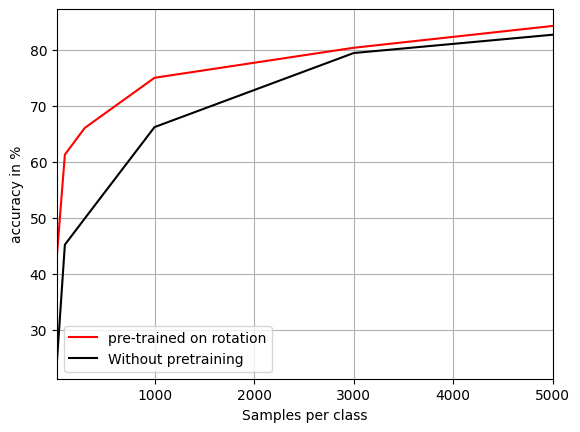

In [160]:
import matplotlib.pyplot as plt

x = [20, 100, 300, 1000, 3000, 5000]

plt.plot(x,pretrained.values(), color = "red", label="pre-trained on rotation")
plt.plot(x,non_pretrained.values(), color = "black", label="Without pretraining")
plt.legend()
plt.grid(True)
plt.xlim(20,5000)
plt.ylabel("accuracy in %")
plt.xlabel("Samples per class")
plt.show()

In [2]:
help(resnet18)

Help on function resnet18 in module torchvision.models.resnet:

resnet18(*, weights: Optional[torchvision.models.resnet.ResNet18_Weights] = None, progress: bool = True, **kwargs: Any) -> torchvision.models.resnet.ResNet
    ResNet-18 from `Deep Residual Learning for Image Recognition <https://arxiv.org/abs/1512.03385>`__.
    
    Args:
        weights (:class:`~torchvision.models.ResNet18_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.ResNet18_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the
            download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.resnet.ResNet``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py>`_
            for m

In [14]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet34(weights="IMAGENET1K_V1")  # Load a ResNet-34 pretrained on ImageNet

num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace final layer

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
run_test(model,testloader,criterion,"classification")

TESTING:
Accuracy of the network on the 10000 test images: 11.06 %
Average loss on the 10000 test images: 2.507


## ImageNette :

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import random

import matplotlib.pyplot as plt
import torchvision
import numpy as np


def rotate_img(img, rot):
    if rot == 0:
        return img
    elif rot == 1:
        return transforms.functional.rotate(img, 90)
    elif rot == 2:
        return transforms.functional.rotate(img, 180)
    elif rot == 3:
        return transforms.functional.rotate(img, 270)
    else:
        raise ValueError("Rotation should be 0, 90, 180, or 270 degrees")

class ImagenetteRotation(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root=root, transform=transform)

    def __getitem__(self, index):
        image, class_label = super().__getitem__(index)

        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        return image, image_rotated, torch.tensor(rotation_label).long(), torch.tensor(class_label).long() 

In [2]:
transform_train = transforms.Compose([
    # transforms.RandomResizedCrop(400), 
    transforms.Resize((400,400)), 
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.5, saturation=0.9, hue=0.4),
    # transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

transform_test = transforms.Compose([
    transforms.Resize(320), 
    transforms.CenterCrop(320), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]) 

In [3]:
batch_size = 128

trainset = ImagenetteRotation(root="./data/imagenette/train", transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, multiprocessing_context='fork')

testset = ImagenetteRotation(root="./data/imagenette/val", transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, multiprocessing_context='fork')

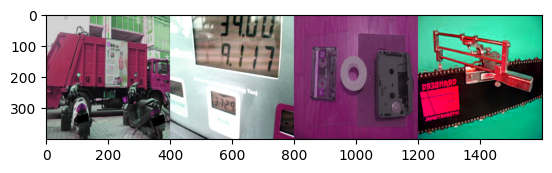

Class labels:  Garbage Truck Gas Pump Cassette Player Chain Saw


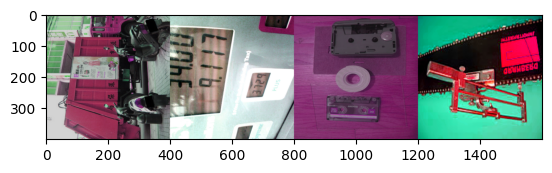

Rotation labels:  90    90    90    180  


In [5]:
import gc

classes = ('Trench', 'English Springer Spaniel', 'Cassette Player', 'Chain Saw', 'Church', 'French Horn', 'Garbage Truck', 'Gas Pump', 'Golf Ball', 'Parachute')
rot_classes = ('0', '90', '180', '270')


def imshow(img):
    img = transforms.Normalize((0, 0, 0), (1/0.229, 1/0.224, 1/0.225))(img)
    img = transforms.Normalize((-0.485, -0.456, -0.406), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))
# del img_grid

## Rotation Prediction on ImageNette Dataset

In [7]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [8]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [9]:
def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results
            predicted = torch.max(outputs,dim=1).indices

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net,testloader,criterion,task)

    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=50, decay_epochs=15, init_lr=0.001, task='rotation')

print('Saving Model ...')
# TODO: Save the model
torch.save({"parameters":net.state_dict(), "optimizer":optimizer.state_dict()}, "./models/imagenette_rotation.pth")
print('Saved Model !')

KeyboardInterrupt: 